# Mercari Price Suggestion Challenge

**Have you ever tried selling your old smartphone, but cannot figure out what would be a fair price? What if you undervalue it and you lose money? Or what if you set the price so high that nobody wants to buy it?**

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost 335 dollars and the other cost 9.99 dollars. Can you guess which one’s which?

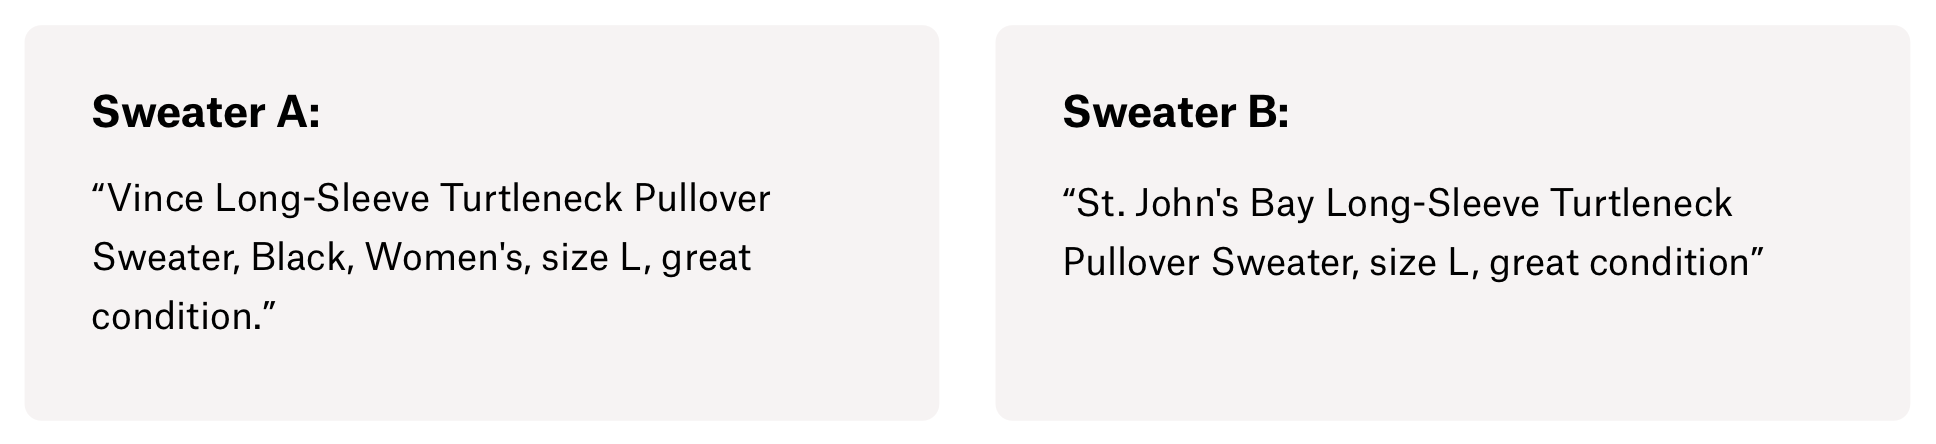

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.


[Mercari](https://www.mercari.com/), Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this [competition](https://www.kaggle.com/c/mercari-price-suggestion-challenge), Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

# MapMarket Price Recomendator

Imports

In [34]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import joblib

## Data Prepocesing


Import the Dataframe

In [35]:
df = pd.read_csv('train.tsv', sep='\t')

Display the first few rows of the DataFrame

In [36]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


Remove `train_id` and `shipping` columns

In [37]:
df = df.drop(['train_id', 'shipping'], axis=1)

Remove all the information before the last forward slash in each string of the `category_name` column

In [38]:
df['category_name'] = df['category_name'].str.rsplit('/', n=1).str[-1].str.strip()

Display the first few rows of the new DataFrame

In [39]:
df

,name,item_condition_id,category_name,brand_name,price,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,T-shirts,NaN,10.0,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Components & Parts,Razer,52.0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Blouse,Target,10.0,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home Décor Accents,NaN,35.0,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Necklaces,NaN,44.0,Complete with certificate of authenticity
...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Mid-Calf,Free People,20.0,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Dresses,Disney,14.0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Fitness accessories,NaN,12.0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home Décor Accents,NaN,45.0,There is 2 of each one that you see! So 2 red ...


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   item_description   1482529 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 67.9+ MB


## Data Cleaning

Identify and print the number of missing values

In [41]:
print('There are %d sales that do not have a category name' % df['category_name'].isnull().sum())
print('There are %d sales that do not have a brand name' % df['brand_name'].isnull().sum())
print('There are %d sales that do not have a description' % df['item_description'].isnull().sum())
print('There are %d sales that have "No description yet" as the sale description' % (df['item_description'] == 'No description yet').sum())
print('There are %d sales where the price was zero' % (df['price'] == 0).sum())

There are 6327 sales that do not have a category name
There are 632682 sales that do not have a brand name
There are 6 sales that do not have a description
There are 82489 sales that have "No description yet" as the sale description
There are 874 sales where the price was zero


Delete sales that do not have a category name 

In [42]:
df.dropna(subset=['category_name'], inplace=True)

Fill missing values in the `brand_name` column with the string ' '

In [43]:
df['brand_name'].fillna(value='', inplace=True)

Delete sales that do not have a description

In [44]:
df.dropna(subset=['item_description'], inplace=True)

Delete sales that have "No description yet" as the sale description

In [45]:
df = df[df['item_description'] != 'No description yet']

Delete sales where the price was zero

In [46]:
df = df[df['price'] != 0]

In [47]:
df

,name,item_condition_id,category_name,brand_name,price,item_description
1,Razer BlackWidow Chroma Keyboard,3,Components & Parts,Razer,52.0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Blouse,Target,10.0,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home Décor Accents,,35.0,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Necklaces,,44.0,Complete with certificate of authenticity
5,Bundled items requested for Ruie,3,Other,,59.0,"Banana republic bottoms, Candies skirt with ma..."
...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Mid-Calf,Free People,20.0,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Dresses,Disney,14.0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Fitness accessories,,12.0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home Décor Accents,,45.0,There is 2 of each one that you see! So 2 red ...


## Feature Engineering:

Convert `item_condition_id`, `category_name`, and `brand_name` columns to categorical data type

In [48]:
df['item_condition_id'] = df['item_condition_id'].astype('category')
df['category_name'] = df['category_name'].astype('category')
df['brand_name'] = df['brand_name'].astype('category')

In [49]:
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

Count vectorize `name` and `category_name` columns

In [50]:
cv_name = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv_name.fit_transform(df['name'])

cv_category = CountVectorizer()
X_category = cv_category.fit_transform(df['category_name'])

TF-IDF Vectorize `item_description` column

In [51]:
tv_description = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv_description.fit_transform(df['item_description'])

Label binarize `brand_name` column

In [52]:
lb_brand = LabelBinarizer(sparse_output=True)
X_brand = lb_brand.fit_transform(df['brand_name'])

Hot encode `item_condition_id` column

In [53]:
encoder_condition = OneHotEncoder(sparse_output=True)
X_condition = encoder_condition.fit_transform(df[['item_condition_id']])

Create sparse df:

- `hstack`: This function horizontally concatenates X_name, X_category, X_description, X_brand, and X_condition matrices.

- `tocsr()`: This method converts the concatenated matrix into a Compressed Sparse Row (CSR) format. CSR is a space-efficient representation of sparse matrices.

In [54]:
X = hstack((X_name, X_category, X_description, X_brand, X_condition)).tocsr()

In [56]:
y = np.log1p(df['price'])

Separate train and test data from sparse merge

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LightGBM Model Training

Create a LightGBM dataset for training

In [58]:
train_data = lgb.Dataset(X_train, label=y_train)

Specify the LightGBM model parameters in a dictionary.

In [59]:
params = {
    'learning_rate': 0.75,
    'application': 'regression',
    'max_depth': 3,
    'num_leaves': 100,
    'verbosity': -1,
    'metric': 'RMSE',
}

Train the LightGBM model

In [60]:
gbm = lgb.train(params, train_set=train_data, num_boost_round=3200)

## Model Prediction

Uses the trained LightGBM model to predict on the test set.

In [61]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

## Model Evaluation

Compare real values with predictions

In [74]:
comparison_df = pd.DataFrame({'y_test (log)': y_test, 'y_pred (log)': y_pred, 'y_test': np.expm1(y_test), 'y_pred': np.expm1(y_pred)})
comparison_df

,y_test (log),y_pred (log),y_test,y_pred
1140309,3.044522,2.816146,20.0,15.712311
1075518,3.610918,3.330460,36.0,26.951197
621185,3.332205,2.960512,27.0,18.307862
1182787,2.197225,2.451631,8.0,10.607258
1141343,2.397895,3.057743,10.0,20.279481
...,...,...,...,...
435961,2.397895,2.744020,10.0,14.549364
487592,3.583519,2.988244,35.0,18.850788
420568,3.610918,3.239671,36.0,24.525324
1428738,4.369448,3.745495,78.0,41.329944


Evaluates the model performance using the mean absolute error (MAE).

In [62]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.3484178910164403


Evaluates the model performance using the root mean squared error (RMSE).

In [63]:
print('Root Mean Squared Error:', mean_squared_error(y_test, y_pred) ** 0.5)

Root Mean Squared Error: 0.4636245130224768


## Save Model

Save using joblib

In [64]:
joblib.dump(cv_name, 'cv_name.joblib')
joblib.dump(cv_category, 'cv_category.joblib')
joblib.dump(tv_description, 'tv_description.joblib')
joblib.dump(lb_brand, 'lb_brand.joblib')
joblib.dump(encoder_condition, 'encoder_condition.joblib')

['encoder_condition.joblib']

Save the trained LightGBM model

In [65]:

gbm.save_model('lgb_model.txt')